<a href="https://colab.research.google.com/github/juanninocruz/Estadistica/blob/main/Cuaderno18_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**18.7 Taller Clustering de Clientes con modelo jerárquico**

En este taller volvemos a realizar el mismo taller de clusterización de Kmeans y Kmedoids usando
modelos jerárquicos, y vamos a verificar la recomendación de número de clústeres.

**Cargar y Preprocesar los Datos**


Este bloque de código realiza una serie de pasos fundamentales para cargar, procesar y visualizar un conjunto de datos. A continuación, explico cada paso del código proporcionado.

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score

# Cargar los datos desde la URL
url = "https://raw.githubusercontent.com/adiacla/bigdata/refs/heads/master/Shopping_CustomerData.csv"
data = pd.read_csv(url)
# Visualizar las primeras filas de los datos
data

,ID,Genero,Edad,Ciudad,Ingresos,Credito,gastos,trabajo
0,1001,Male,49,Bengaluru,527547.58850,653,78,1
1,1002,Male,59,Bengaluru,207143.19760,630,63,1
2,1003,Female,54,Delhi,164423.84570,555,69,4
3,1004,Female,42,Bengaluru,56220.36443,699,30,1
4,1005,Female,30,Bengaluru,256194.36190,793,6,1
...,...,...,...,...,...,...,...,...
195,1196,Female,54,Delhi,317466.42070,601,52,4
196,1197,Female,20,Bengaluru,323305.50020,554,58,1
197,1198,Male,44,Chennai,109058.54430,844,36,2
198,1199,Male,28,Delhi,160116.89300,837,24,4


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        200 non-null    int64  
 1   Genero    200 non-null    object 
 2   Edad      200 non-null    int64  
 3   Ciudad    200 non-null    object 
 4   Ingresos  200 non-null    float64
 5   Credito   200 non-null    int64  
 6   gastos    200 non-null    int64  
 7   trabajo   200 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 12.6+ KB


In [27]:
data.describe()

,ID,Edad,Ingresos,Credito,gastos,trabajo
count,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000
mean,1100.500000,45.520000,285143.931646,719.975000,50.70500,2.850000
std,57.879185,16.113592,169229.187619,104.578236,28.72269,1.475938
min,1001.000000,18.000000,2577.057456,551.000000,2.00000,1.000000
25%,1050.750000,31.750000,153227.340950,628.250000,27.75000,1.750000
50%,1100.500000,46.500000,263418.505550,715.000000,48.00000,3.000000
75%,1150.250000,59.000000,384857.116200,806.250000,77.00000,4.000000
max,1200.000000,75.000000,695407.091700,897.000000,100.00000,5.000000


In [28]:
data.isnull().sum()

,0
ID,0
Genero,0
Edad,0
Ciudad,0
Ingresos,0
Credito,0
gastos,0
trabajo,0


**Verificar que no hayan outliers**


El código genera un gráfico de caja y bigotes (boxplot) para las columnas numéricas del conjunto de datos.

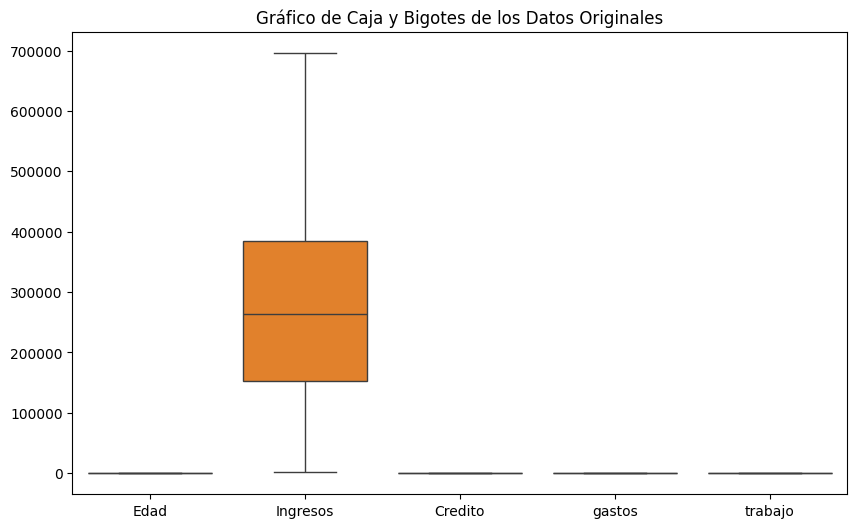

In [29]:
# Seleccionar sólo las columnas numéricas
numerical_data = data[['Edad', 'Ingresos', 'Credito', 'gastos', 'trabajo']]
# Crear el gráfico de caja y bigotes
plt.figure(figsize=(10, 6))
sns.boxplot(data=numerical_data)
plt.title('Gráfico de Caja y Bigotes de los Datos Originales')
plt.show()

**Codificar la variable 'Genero' (Male = 0, Female = 1):**


Primero, se codifica la variable categórica 'Genero' (Male = 0, Female = 1) para convertirla en una forma numérica. Luego, se seleccionan las columnas numéricas relevantes para el análisis (Edad, Ingresos, Credito, Gastos, Trabajo, y Genero), y se eliminan las no necesarias, como ID y Ciudad.

A continuación, normalizamos los datos utilizando el StandardScaler de scikit-learn, asegurando que todas las variables tengan la misma escala (media 0 y desviación estándar 1). Esto es crucial para que ninguna variable, como Ingresos, domine las distancias calculadas en el algoritmo K-means. El
resultado es un conjunto de datos listos para ser procesados y segmentados en grupos utilizando técnicas de clustering.

In [30]:
# Codificar la variable 'Genero' (Male = 0, Female = 1)
data['Genero'] = data['Genero'].map({'Male': 0, 'Female': 1})
# Seleccionar las columnas numéricas para la segmentación (eliminando ID y Ciudad)
data_numeric = data[['Edad', 'Ingresos', 'Credito', 'gastos', 'trabajo', 'Genero']]
# Normalizar los datos numéricos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)
# Visualizar las primeras filas de los datos escalados
data_scaled

array([[ 0.2165087 ,  1.43599311, -0.64203672,  0.95267867, -1.25658588,
        -1.12815215],
       [ 0.83866013, -0.46207437, -0.86251966,  0.42913296, -1.25658588,
        -1.12815215],
       [ 0.52758441, -0.71514273, -1.58148576,  0.63855125,  0.78112095,
         0.88640526],
       ...,
       [-0.09456702, -1.04312537,  1.18893027, -0.51324931, -0.57735027,
        -1.12815215],
       [-1.0900093 , -0.74065701,  1.12182677, -0.93208587,  0.78112095,
        -1.12815215],
       [-0.28121245, -0.02999037,  0.66168846, -0.68776454, -0.57735027,
        -1.12815215]])

**Generar el dendrograma**

El siguiente paso es generar un dendrograma para visualizar cómo las observaciones o puntos de datos se agrupan en el proceso de clustering jerárquico. Este gráfico permite identificar las relaciones jerárquicas entre los datos e ir analizando dónde estaría el número óptimo de clústeres realizando un "corte" horizontal en el dendrograma.

Aspectos considerados en este paso
* Escalamiento de los datos: *texto en cursiva*
Antes de aplicar el clustering jerárquico, los datos deben ser escalados para garantizar que todas las características tengan la misma importancia en el cálculo de distancias. Esto se logra a través de técnicas como la estandarización (z-score) o min-max ya vistas en este curso, y que aplicaron en el paso anterior.
* Matriz de linkage *texto en cursiva*
El cálculo de la matriz de linkage es esencial para el clustering jerárquico. En este caso, se utiliza el método de Ward, que minimiza la varianza intraclúster a medida que se combinan los clústeres.
Otros métodos, como single, complete o average linkage, podrían haber sido seleccionados dependiendo del caso de estudio.
* Ejes del dendrograma
Eje X: representa las muestras o puntos de datos, ordenados de manera que las fusiones entre clústeres sean claras. Eje Y: muestra la distancia o disimilitud entre clústeres. Cuanto mayor es la altura de una unión, más diferentes son los clústeres fusionados.

*Corte del dendrograma*


El dendrograma proporciona una guía para elegir el número de clústeres. Un corte horizontal a una cierta altura divide las ramas en clústeres separados. La altura del corte refleja el nivel de similitud aceptado para agrupar observaciones.

**Visualización de las relaciones**

Las fusiones que ocurren a menor altura indican mayor similitud entre los datos combinados y las fusiones a mayor altura representan una menor similitud y, por lo tanto, clústeres más heterogéneos.
Esta visualización es crucial para interpretar cómo se forman los grupos y decidir el número final de clústeres para el análisis. Vamos a generarlo con los métodos: wards, complete y average, y
compara los dendrogramas.

Método “ward”

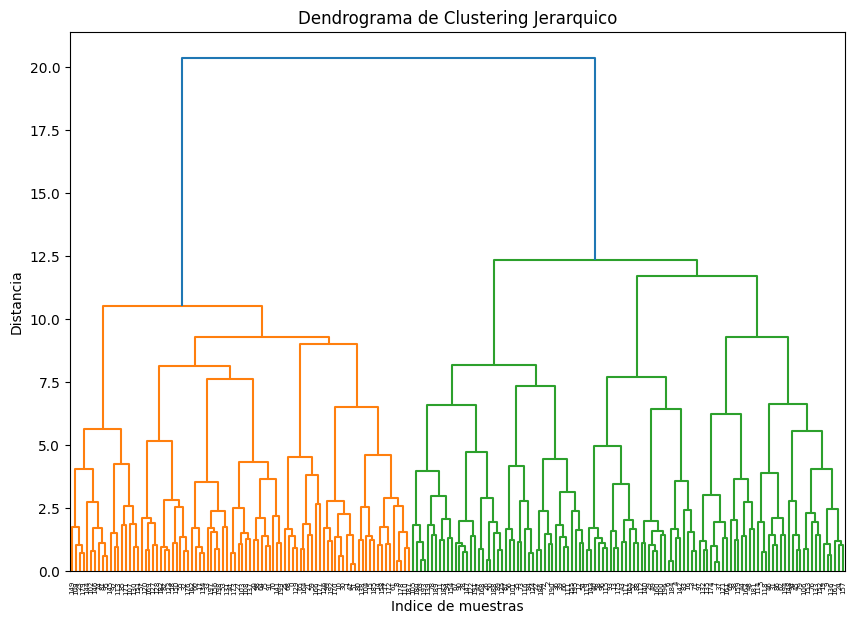

In [31]:
# Generar dendrograma con el método ward
linkage_matrix = linkage(data_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title("Dendrograma de Clustering Jerarquico")
plt.xlabel("Indice de muestras")
plt.ylabel("Distancia")
plt.show()

***Método ‘Average’***


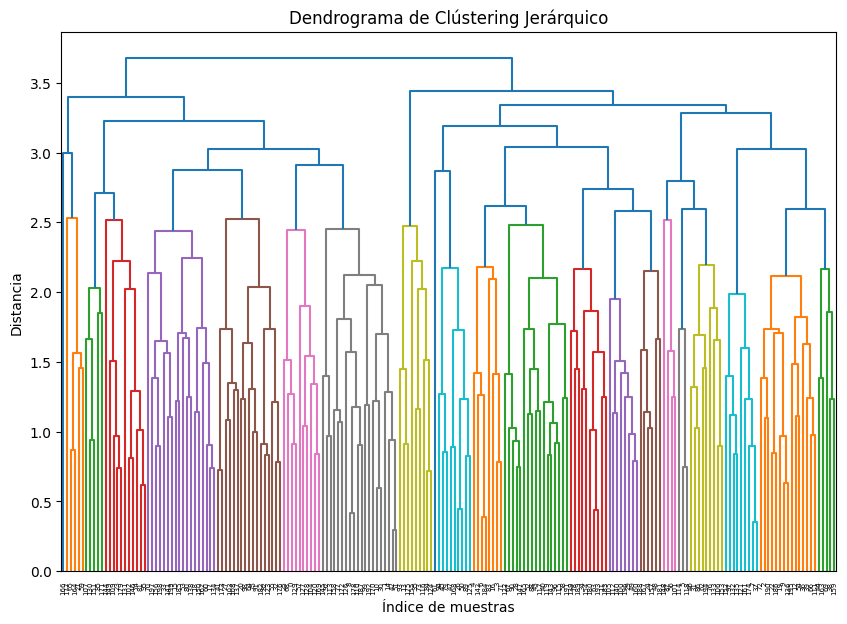

In [32]:
# Generar dendrograma con el método Average
linkage_matrix = linkage(data_scaled, method='average')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title("Dendrograma de Clústering Jerárquico")
plt.xlabel("Índice de muestras")
plt.ylabel("Distancia")
plt.show()

**Método ‘Complete’**

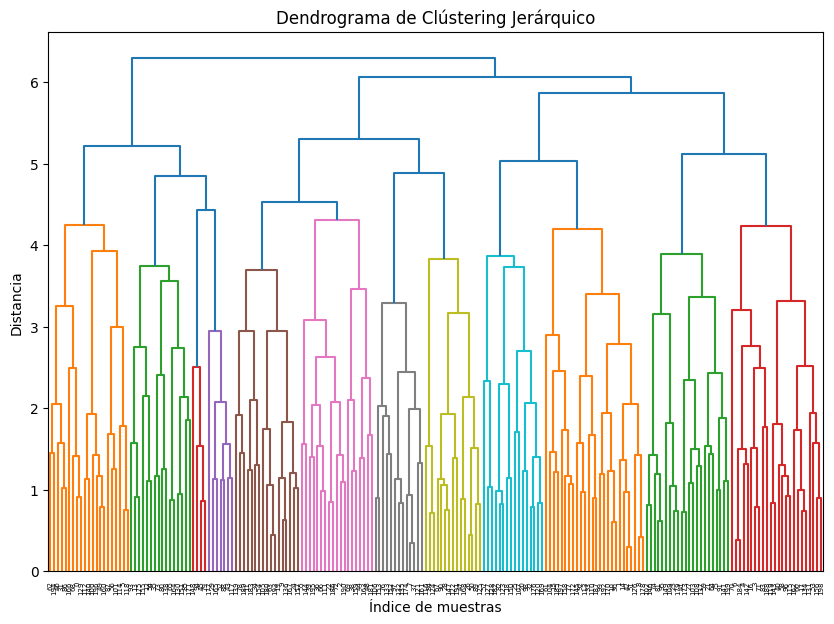

In [33]:
# Generar dendrograma con el método Complete
linkage_matrix = linkage(data_scaled, method='complete')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title("Dendrograma de Clústering Jerárquico")
plt.xlabel("Índice de muestras")
plt.ylabel("Distancia")
plt.show()

Seleccionamos un método ward donde la gráfica (en la mayor altura o jerarquía) podemos cortar el dendrograma, por ejemplo, a una altura de 7.5 para verificar cuántos clústeres se crean y en la
gráfica se aprecia que la línea corta 12 ejes, lo que significa crear 12 grupos.

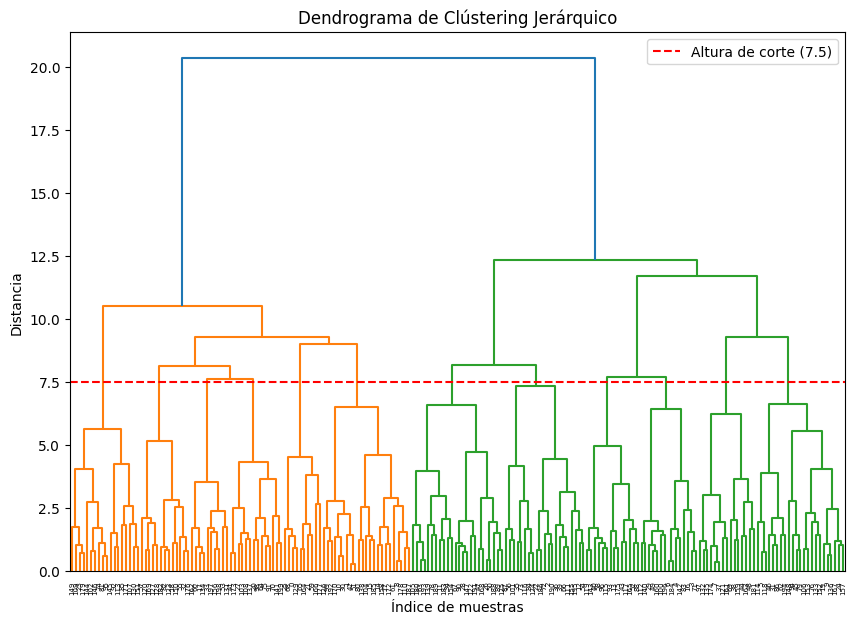

In [34]:
# Generar dendrograma con el método Ward
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
linkage_matrix = linkage(data_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
# Añadir título y etiquetas
plt.title("Dendrograma de Clústering Jerárquico")
plt.xlabel("Índice de muestras")
plt.ylabel("Distancia")
# Trazar línea horizontal a la altura de 7.5
plt.axhline(y=7.5, color='r', linestyle='--', label='Altura de corte (7.5)')
# Mostrar leyenda y gráfico
plt.legend()
plt.show()

**Corte del dendrograma a distancia fija 7.5 y el criterio ‘distance’**

In [35]:
# --- cortar por distancia fija ---
clústeres_by_distance = fcluster(linkage_matrix, t=7.5, criterion='distance')
print("Grupos creados al cortar por distancia fija (7.5):")
print(pd.Series(clústeres_by_distance).value_counts())

Grupos creados al cortar por distancia fija (7.5):
7     24
6     23
12    23
8     21
1     18
10    15
11    15
9     14
4     14
2     13
5     10
3     10
Name: count, dtype: int64


**Corte del dendrograma por número fijo de clústeres (12) y el criterio ‘maxclust’**

In [36]:
# --- Versión 2: Cortar por número fijo de clústeres ---
num_clusters = 12 # Cambiar según el caso deseado
clusters_by_number = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')
print(f"Grupos creados para {num_clusters} clusters:")
print(pd.Series(clusters_by_number).value_counts())

Grupos creados para 12 clusters:
7     24
6     23
12    23
8     21
1     18
10    15
11    15
9     14
4     14
2     13
5     10
3     10
Name: count, dtype: int64


**Asignamos el clúster a cada cliente**

In [37]:
#Asignar el clúster a cada cliente
data['Cluster'] = clusters_by_number
data

,ID,Genero,Edad,Ciudad,Ingresos,Credito,gastos,trabajo,Cluster
0,1001,0,49,Bengaluru,527547.58850,653,78,1,5
1,1002,0,59,Bengaluru,207143.19760,630,63,1,6
2,1003,1,54,Delhi,164423.84570,555,69,4,8
3,1004,1,42,Bengaluru,56220.36443,699,30,1,10
4,1005,1,30,Bengaluru,256194.36190,793,6,1,10
...,...,...,...,...,...,...,...,...,...
195,1196,1,54,Delhi,317466.42070,601,52,4,8
196,1197,1,20,Bengaluru,323305.50020,554,58,1,10
197,1198,0,44,Chennai,109058.54430,844,36,2,3
198,1199,0,28,Delhi,160116.89300,837,24,4,3


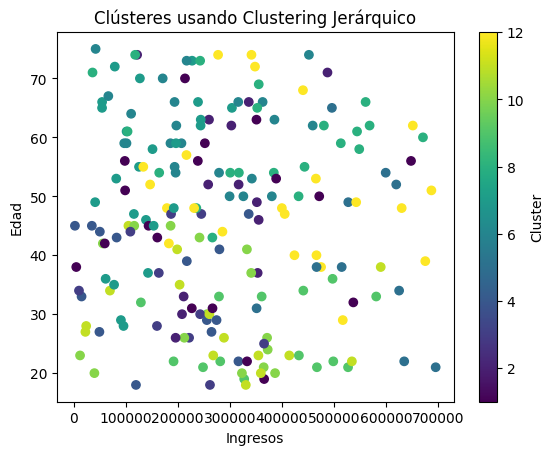

Coeficiente de silueta promedio: 0.1450744435440566


In [41]:
# Visualizar clústeres
plt.scatter(data['Ingresos'], data['Edad'], c=data['Cluster'], cmap='viridis')
plt.title("Clústeres usando Clustering Jerárquico")
plt.xlabel('Ingresos')
plt.ylabel('Edad')
plt.colorbar(label='Cluster')
plt.show()
# Evaluar con coeficiente de silueta
silhouette_avg = silhouette_score(data_scaled, data['Cluster'])
print(f"Coeficiente de silueta promedio: {silhouette_avg}")

El Coeficiente de silueta promedio: 0.1450744435440566. Este se compara con el coeficiente silueta
de los otros métodos usados para seleccionar el más alto.